In [1]:
%load_ext autoreload
%autoreload 2



In [2]:
#%%
from ntm import NTM
from dataloader import repeat_copy_dataloader
from torch import nn, optim
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm 
#%%

In [3]:
seq_width=8
min_seq_len = 1
max_seq_len = 10
min_repeat = 1
max_repeat = 10

input_size=seq_width+2
output_size= seq_width+1
controller_size=100
memory_units=128
memory_unit_size=20
batch_size=1
num_heads=1
total_iteration =30000
num_batches = total_iteration//batch_size 



In [6]:
device = torch.device("cpu")
data = repeat_copy_dataloader(num_batches=num_batches,
                              batch_size=batch_size,
                              seq_width=seq_width,
                              min_seq_len=min_seq_len,
                              max_seq_len=max_seq_len,
                              min_repeat= min_repeat,
                              max_repeat= max_repeat,
                              device = device
                             )

ntm = NTM(input_size,output_size,controller_size,memory_units,memory_unit_size,num_heads,device)

criterion = nn.BCELoss()
optimizer = optim.RMSprop(ntm.parameters(),
                          lr=1e-4,
                          alpha=0.95,
                          momentum=0.9)

In [7]:
#%%
print("Starting training")
print_every = 100
losses =[]
errors =[]
for batch, (x,y) in(enumerate(data)):
    optimizer.zero_grad()
    ntm.reset(batch_size)
    
#     print("Sendning inputs")
    for i in range(x.size(0)):
        input = x[i]
        ntm(input)

    outputs = torch.zeros(y.size()).to(device)

    zero_input = torch.zeros([batch_size,input_size]).to(device)
#     print("Finding Outputs")
    for i in range(y.size(0)):
        outputs[i],_ = ntm(zero_input)
    
#     print("Backprop step")
#     print(f"Outputs {outputs}")
#     print(f"y {y}")
    loss = criterion(outputs, y)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_value_(ntm.parameters(), 10)
    optimizer.step()
    
    out_binarized = outputs.clone().data
    out_binarized = out_binarized.cpu().detach().apply_(lambda x: 0 if x < 0.5 else 1).to(device)
    
    # The cost is the number of error bits per sequence
    cost = torch.sum(torch.abs(out_binarized - y.data))
    errors.append(cost.item()/batch_size)
    if (batch%print_every ==0):
        print(f"Finished batch: {batch}, loss:{losses[-1]:.3e}, cost: {errors[-1]}")
        torch.save(ntm.state_dict(), f'checkpoints/repeat_copy/i-{batch}_error_{losses[-1]:.3e}.pt')

Starting training
Finished batch: 0, loss:6.922e-01, cost: 258.0
Finished batch: 100, loss:6.450e-01, cost: 50.0
Finished batch: 200, loss:6.362e-01, cost: 84.0
Finished batch: 300, loss:6.445e-01, cost: 435.0
Finished batch: 400, loss:5.696e-01, cost: 13.0
Finished batch: 500, loss:6.289e-01, cost: 96.0
Finished batch: 600, loss:6.306e-01, cost: 47.0
Finished batch: 700, loss:6.283e-01, cost: 94.0
Finished batch: 800, loss:6.337e-01, cost: 141.0
Finished batch: 900, loss:6.533e-01, cost: 33.0
Finished batch: 1000, loss:6.116e-01, cost: 258.0
Finished batch: 1100, loss:6.687e-01, cost: 18.0
Finished batch: 1200, loss:6.535e-01, cost: 35.0
Finished batch: 1300, loss:3.651e-01, cost: 3.0
Finished batch: 1400, loss:6.408e-01, cost: 106.0
Finished batch: 1500, loss:4.477e-01, cost: 40.0
Finished batch: 1600, loss:5.872e-01, cost: 242.0
Finished batch: 1700, loss:5.248e-01, cost: 72.0
Finished batch: 1800, loss:5.921e-01, cost: 27.0
Finished batch: 1900, loss:5.676e-01, cost: 51.0
Finished 

In [240]:
test = repeat_copy_dataloader(1,1,8,5,5,11,12,device)
x,y = next(test)


In [241]:
mpl.rcParams['figure.dpi']=100
plt.rcParams['image.cmap'] = 'binary_r'
plt.rcParams['image.cmap'] = 'Blues_r'

## Input and Target

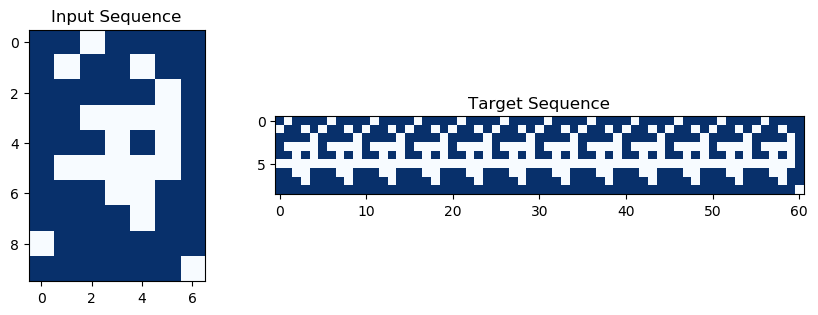

In [242]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,10),gridspec_kw={'width_ratios': [1, 3]})
ax1.imshow(x.squeeze().t())
ax1.set_title("Input Sequence")
ax2.imshow(y.squeeze().t())
ax2.set_title("Target Sequence")
plt.show()

In [243]:
ntm_loaded = NTM(input_size,output_size,controller_size,memory_units,memory_unit_size,num_heads,device)
ntm_loaded.load_state_dict(torch.load("checkpoints/repeat_copy/i-29300_error_3.173e-04.pt"))

In [244]:
import numpy as np
def print_head(h):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,20))
    fig
    h = np.array(h)
    r = h[:,0,:,:]
    w = h[:,1,:,:]
   # ax1.figure(figsize=(10,20))
    ax1.imshow(r.T.squeeze())
    ax1.set_title("Read Head locations")
#     plt.show()
#     plt.figure(figsize=(10,20))
    ax2.imshow(w.T.squeeze())
    ax2.set_title("Write Head locations")
    plt.show()

In [245]:
# model = ntm
model = ntm_loaded
model.reset(batch_size=1)
with torch.no_grad():
    h1 =[]
    for i in range(x.size(0)):
            input = x[i]
            _,head = model(input)
            h1.append(head)
    outputs = torch.zeros(y.size())
    
    zero_input = torch.zeros([1,input_size])
    #     print("Finding Outputs")
    h2 =[]
    for i in range(y.size(0)):
        outputs[i],head = model(zero_input)
        h2.append(head)
    head_weights = np.concatenate((np.array(h1),np.array(h2)),axis=0)




## Output from network 

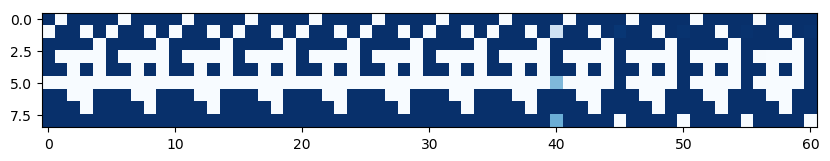

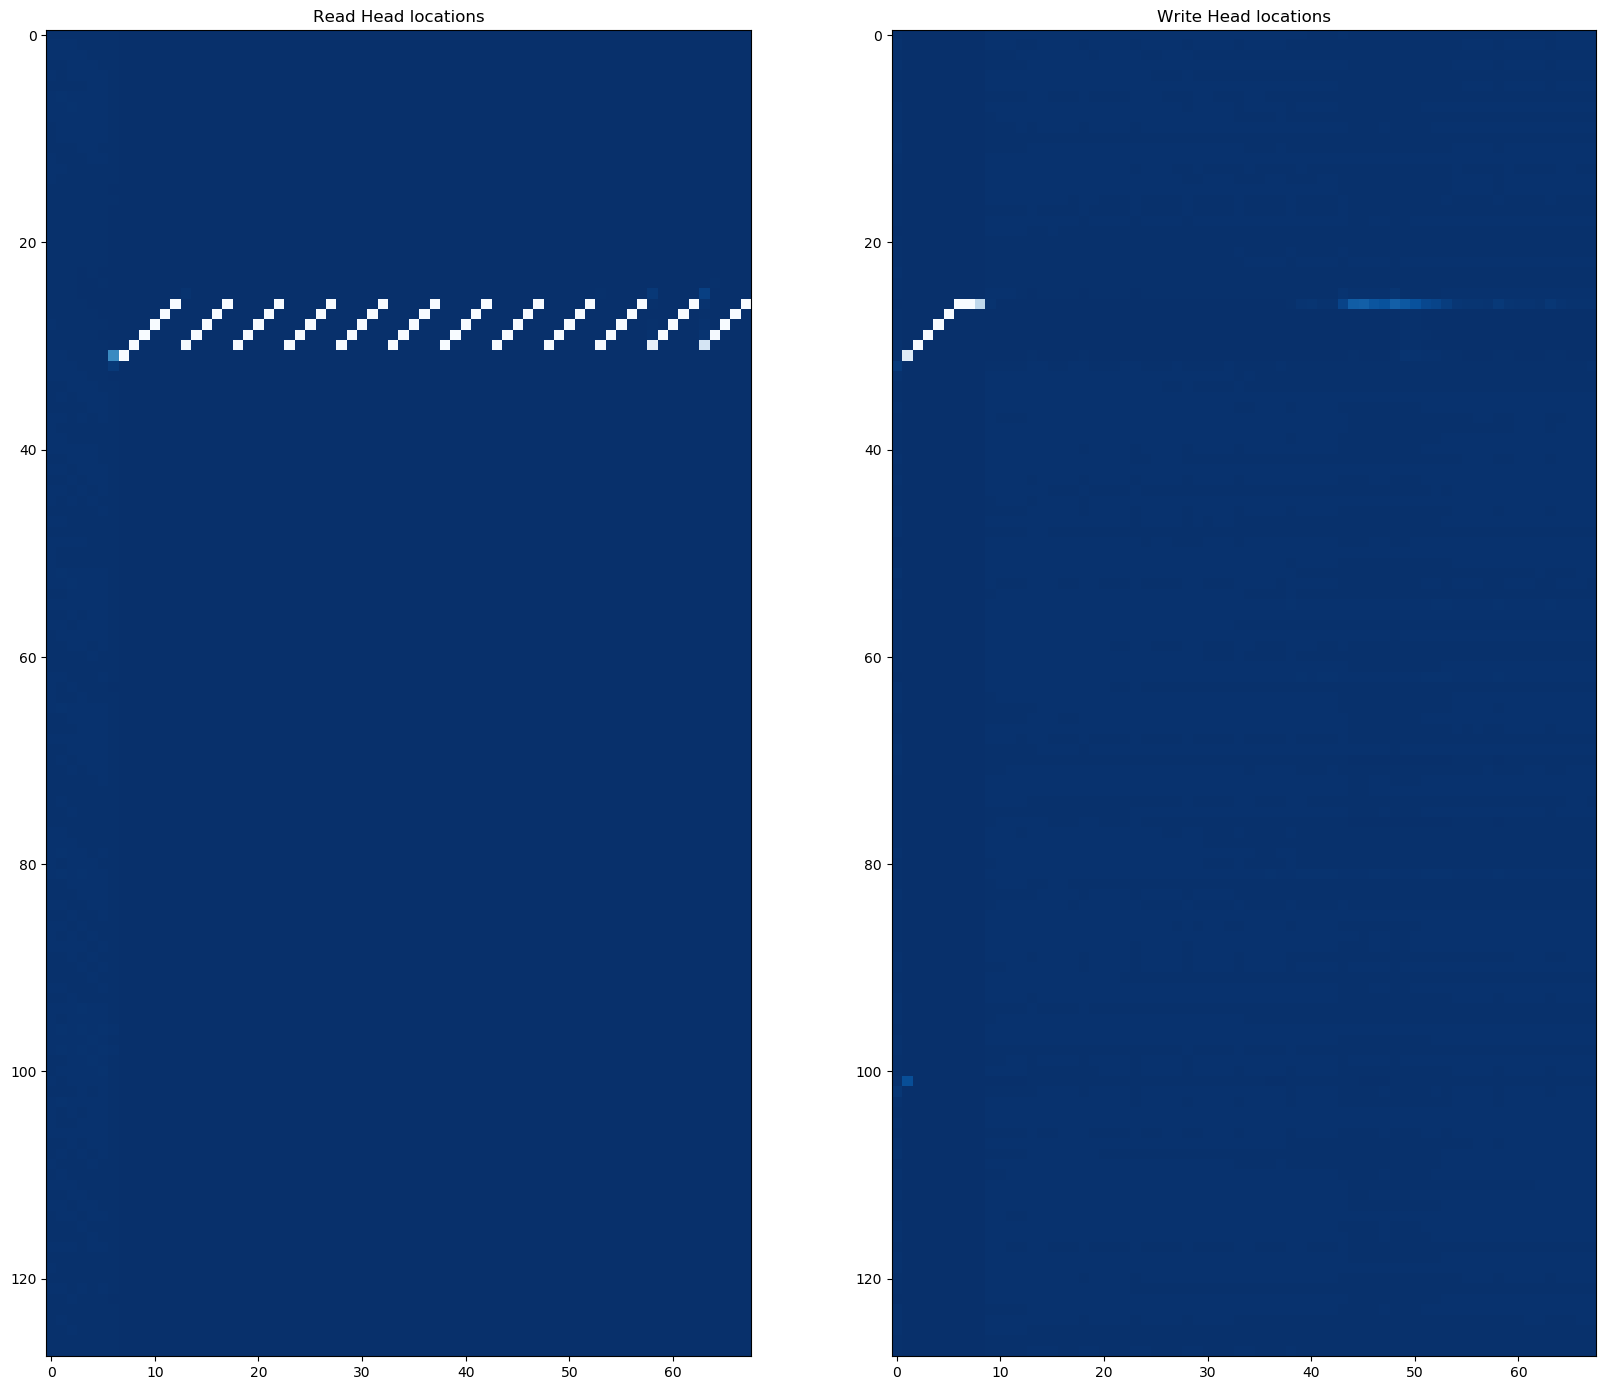

In [246]:
plt.figure(figsize=(10,10))
plt.imshow(outputs.squeeze().t())
print_head(head_weights)

## Error between target and output

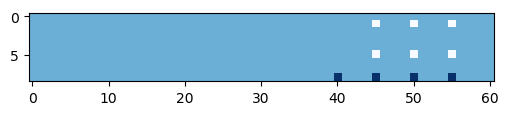

In [247]:
plt.imshow((y-outputs).round().squeeze().t())
plt.show()